In [1]:
import pandas as pd
import numpy as np

### Objective
The goal is to investigate whether or not there is a "home field advantage" for a nation that hosts the Olympic games. This analysis will study the Chinese olympic team, and try to determine if there was an unusually high improvement in performance during the 2008 Summer Olympic Games in Beijing.

### Metrics to Produce
We will look at the following metrics in order to check for a host advantage, considering medal count as the measure for success in an Olympic Games:
- Medal count trends:
    - Did the total medal count increase during the hosted olympics?
    - How many standard deviations (z-score) from the average medal count across all olympic games was the medal count for the hosted games.
    - Where did the host country place on the total medal rankings in their hosted games vs. other games
    - How did the host country's performance metrics compare to the rest of the world's metrics? Does that tell us anything?


In [2]:
# load the csv file for analysis
df = pd.read_csv('resources/athlete_events.csv')

# use only the Summer Olympics for Analysis
summer_df = df[df['Season'] == 'Summer']

In [3]:
# create a dataframe for only the Chinese team, where "China" is anywhere in the team name
china_df = summer_df[summer_df['Team'].str.contains('China')]
# print the unique values of Team column to see if they are all "China"
print(china_df['Team'].unique())
print(china_df['NOC'].unique())
# Clean up the Team column to have only "China" instead of "China-1", "China-2", etc.
china_df.loc[:, 'Team'] = 'China'
print(china_df['Team'].unique())

# It looks like NOC is the same as Team, and doesn't pose as many issues as Team
# Let's use NOC instead of Team for the rest of the analysis

['China' 'China-2' 'China-1' 'China-3']
['CHN']
['China']


In [4]:
# create a dataframe where NOC is not CHN
rest_of_world_df = summer_df[summer_df['NOC'] != 'CHN']

# Clean up the team names to have only the country name
# if "-" appears in the team name, use only the part of the string that comes before "-"
rest_of_world_df.loc[:, 'Team'] = rest_of_world_df['Team'].str.split('-').str[0]


In [44]:
# create a dataframe that is the rest_of_world_df (referred to now as rw) grouped by Games, then NOC
# We can use this to calculate medal counts for each country in each Games
games_df_rw = rest_of_world_df.groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
# This will be, for each NOC, the sum of the medals won in each category for each games
games_df_rw['gold_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Gold'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['silver_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Silver'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['bronze_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Bronze'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
# create a clean column for total medals
games_df_rw['total_medals'] = games_df_rw['Medal'] + games_df_rw['gold_medals'] + games_df_rw['silver_medals'] + games_df_rw['bronze_medals']
# fill NaN values with 0
games_df_rw = games_df_rw.fillna(0)

# format values in all columns except Games to integers
games_df_rw = games_df_rw.astype({'Medal': 'int', 'gold_medals': 'int', 'silver_medals': 'int', 'bronze_medals': 'int'})

games_df_rw


,Games,NOC,Medal,gold_medals,silver_medals,bronze_medals,total_medals
0,1896 Summer,AUS,3,2,1,1,7.0
1,1896 Summer,AUT,5,2,2,2,11.0
2,1896 Summer,DEN,6,1,4,3,14.0
3,1896 Summer,FRA,11,5,3,2,21.0
4,1896 Summer,GBR,9,3,5,3,20.0
...,...,...,...,...,...,...,...
2792,2016 Summer,VIE,2,0,0,0,0.0
2793,2016 Summer,VIN,0,0,0,0,0.0
2794,2016 Summer,YEM,0,0,0,0,0.0
2795,2016 Summer,ZAM,0,0,0,0,0.0


In [22]:
# create a dataframe for the Chinese team in the Summer Olympics grouped by Games. 
games_df_china = china_df.groupby('Games').agg({'Medal': 'count'})

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
games_df_china['gold_medals'] = china_df[china_df['Medal'] == 'Gold'].groupby('Games').agg({'Medal': ['count']})
games_df_china['silver_medals'] = china_df[china_df['Medal'] == 'Silver'].groupby('Games').agg({'Medal': ['count']})
games_df_china['bronze_medals'] = china_df[china_df['Medal'] == 'Bronze'].groupby('Games').agg({'Medal': ['count']})

# fill NaN values with 0
games_df_china = games_df_china.fillna(0)

# format values in all columns except Games to integers
games_df_china = games_df_china.astype(int)

games_df_china

,Medal,gold_medals,silver_medals,bronze_medals
Games,,,,
1932 Summer,0,0,0,0
1936 Summer,0,0,0,0
1948 Summer,0,0,0,0
1952 Summer,0,0,0,0
1984 Summer,74,24,13,37
1988 Summer,52,6,16,30
1992 Summer,82,18,45,19
1996 Summer,106,19,70,17
2000 Summer,79,39,23,17


In [27]:
# create a cleaner "total_medals" column
games_df_china['total_medals'] = games_df_china[['gold_medals', 'silver_medals', 'bronze_medals']].sum(axis=1)

# Add a column for non-medal participations, which is the count of all rows for Games where Medal is NaN
games_df_china['non_medal_participations'] = china_df[china_df['Medal'].isnull()].groupby('Games').size()

# Add a column for total participations, which is the count of all rows for Games.
# This includes 0 or NaN values for medals
games_df_china['total_participations'] = china_df.groupby('Games').size()
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,non_medal_participations,total_participations,total_medals
Games,,,,,,,
1932 Summer,0,0,0,0,2,2,0
1936 Summer,0,0,0,0,65,65,0
1948 Summer,0,0,0,0,33,33,0
1952 Summer,0,0,0,0,1,1,0
1984 Summer,74,24,13,37,249,323,74
1988 Summer,52,6,16,30,375,427,52
1992 Summer,82,18,45,19,312,394,82
1996 Summer,106,19,70,17,332,438,106
2000 Summer,79,39,23,17,335,414,79


In [28]:
# Create a column called 'medal_rate' which is the ratio of medal count to total participation count
games_df_china['medal_rate'] = games_df_china['total_medals'] / games_df_china['total_participations']
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,non_medal_participations,total_participations,total_medals,medal_rate
Games,,,,,,,,
1932 Summer,0,0,0,0,2,2,0,0.000000
1936 Summer,0,0,0,0,65,65,0,0.000000
1948 Summer,0,0,0,0,33,33,0,0.000000
1952 Summer,0,0,0,0,1,1,0,0.000000
1984 Summer,74,24,13,37,249,323,74,0.229102
1988 Summer,52,6,16,30,375,427,52,0.121780
1992 Summer,82,18,45,19,312,394,82,0.208122
1996 Summer,106,19,70,17,332,438,106,0.242009
2000 Summer,79,39,23,17,335,414,79,0.190821


In [29]:
# create columns called gold_percentage, silver_percentage, bronze_percentage and non_medal_percentage
games_df_china['gold_percentage'] = games_df_china['gold_medals'] / games_df_china['total_medals']
games_df_china['silver_percentage'] = games_df_china['silver_medals'] / games_df_china['total_medals']
games_df_china['bronze_percentage'] = games_df_china['bronze_medals'] / games_df_china['total_medals']
games_df_china['non_medal_percentage'] = games_df_china['non_medal_participations'] / games_df_china['total_participations']

games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,non_medal_participations,total_participations,total_medals,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage
Games,,,,,,,,,,,,
1932 Summer,0,0,0,0,2,2,0,0.000000,NaN,NaN,NaN,1.000000
1936 Summer,0,0,0,0,65,65,0,0.000000,NaN,NaN,NaN,1.000000
1948 Summer,0,0,0,0,33,33,0,0.000000,NaN,NaN,NaN,1.000000
1952 Summer,0,0,0,0,1,1,0,0.000000,NaN,NaN,NaN,1.000000
1984 Summer,74,24,13,37,249,323,74,0.229102,0.324324,0.175676,0.500000,0.770898
1988 Summer,52,6,16,30,375,427,52,0.121780,0.115385,0.307692,0.576923,0.878220
1992 Summer,82,18,45,19,312,394,82,0.208122,0.219512,0.548780,0.231707,0.791878
1996 Summer,106,19,70,17,332,438,106,0.242009,0.179245,0.660377,0.160377,0.757991
2000 Summer,79,39,23,17,335,414,79,0.190821,0.493671,0.291139,0.215190,0.809179


<Axes: xlabel='Games'>

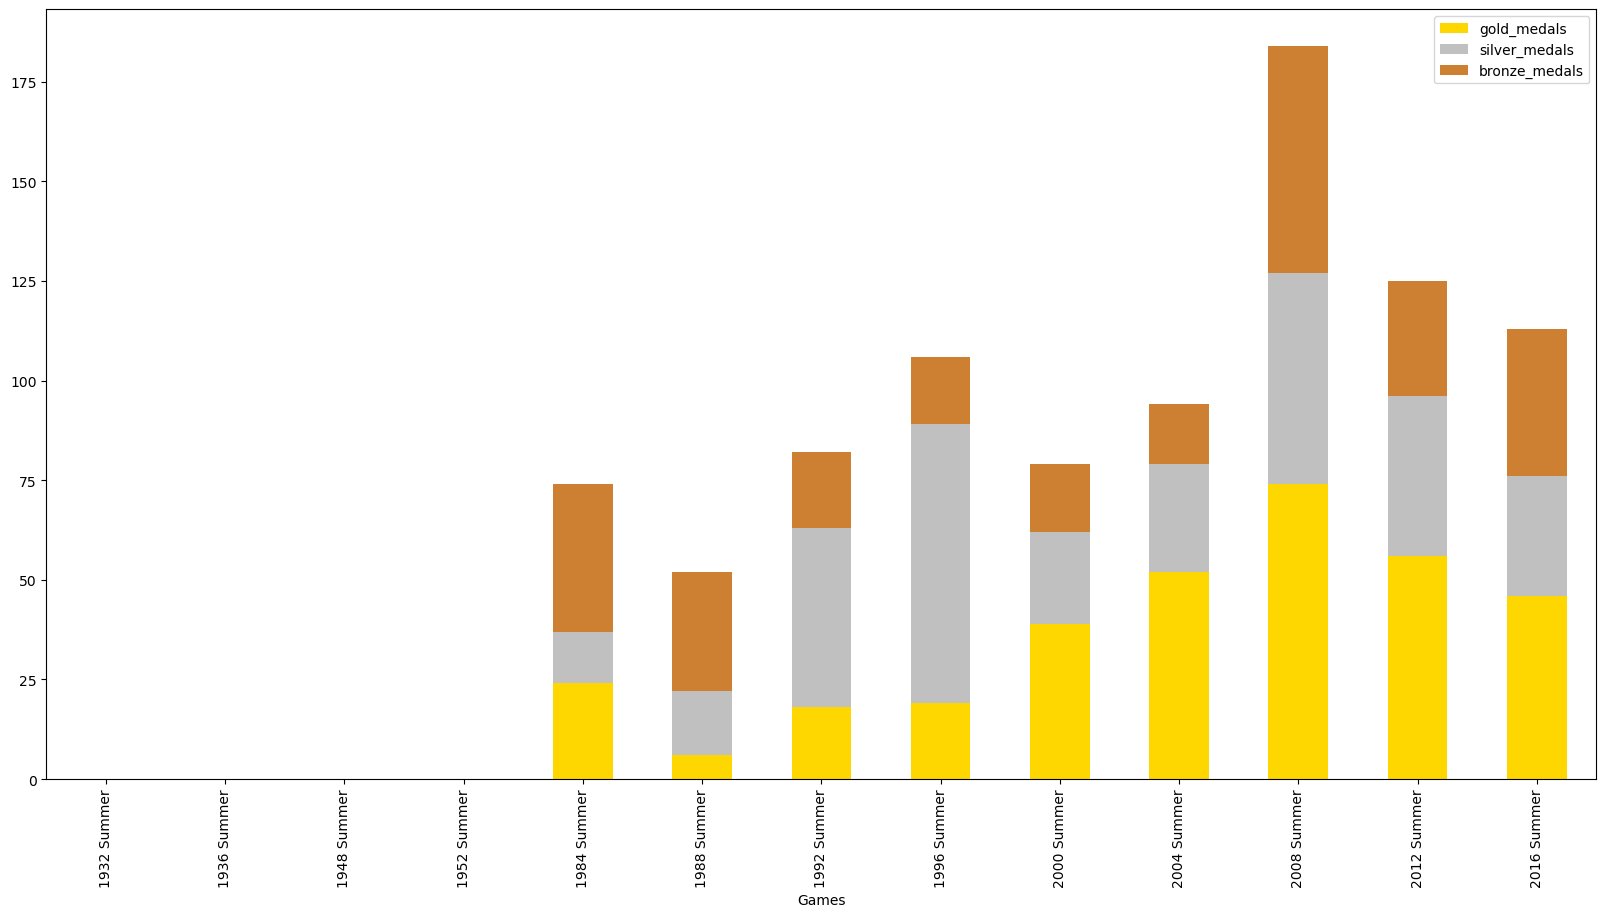

In [30]:
# Plot the gold_medals, silver_medals, bronze_medals and non_medal_participations for the Chinese team in the Summer Olympics.
# Use a stacked bar chart, where the total size of the bar is the total_participations

import matplotlib.pyplot as plt
games_df_china[['gold_medals', 'silver_medals', 'bronze_medals']].plot(
                                    kind='bar',
                                    stacked=True,
                                    figsize=(20, 10),
                                    color=['#ffd700', '#c0c0c0', '#cd7f32'])
# use #ffd700 for gold, #c0c0c0 for silver and #cd7f32 for bronze



<Axes: xlabel='Games'>

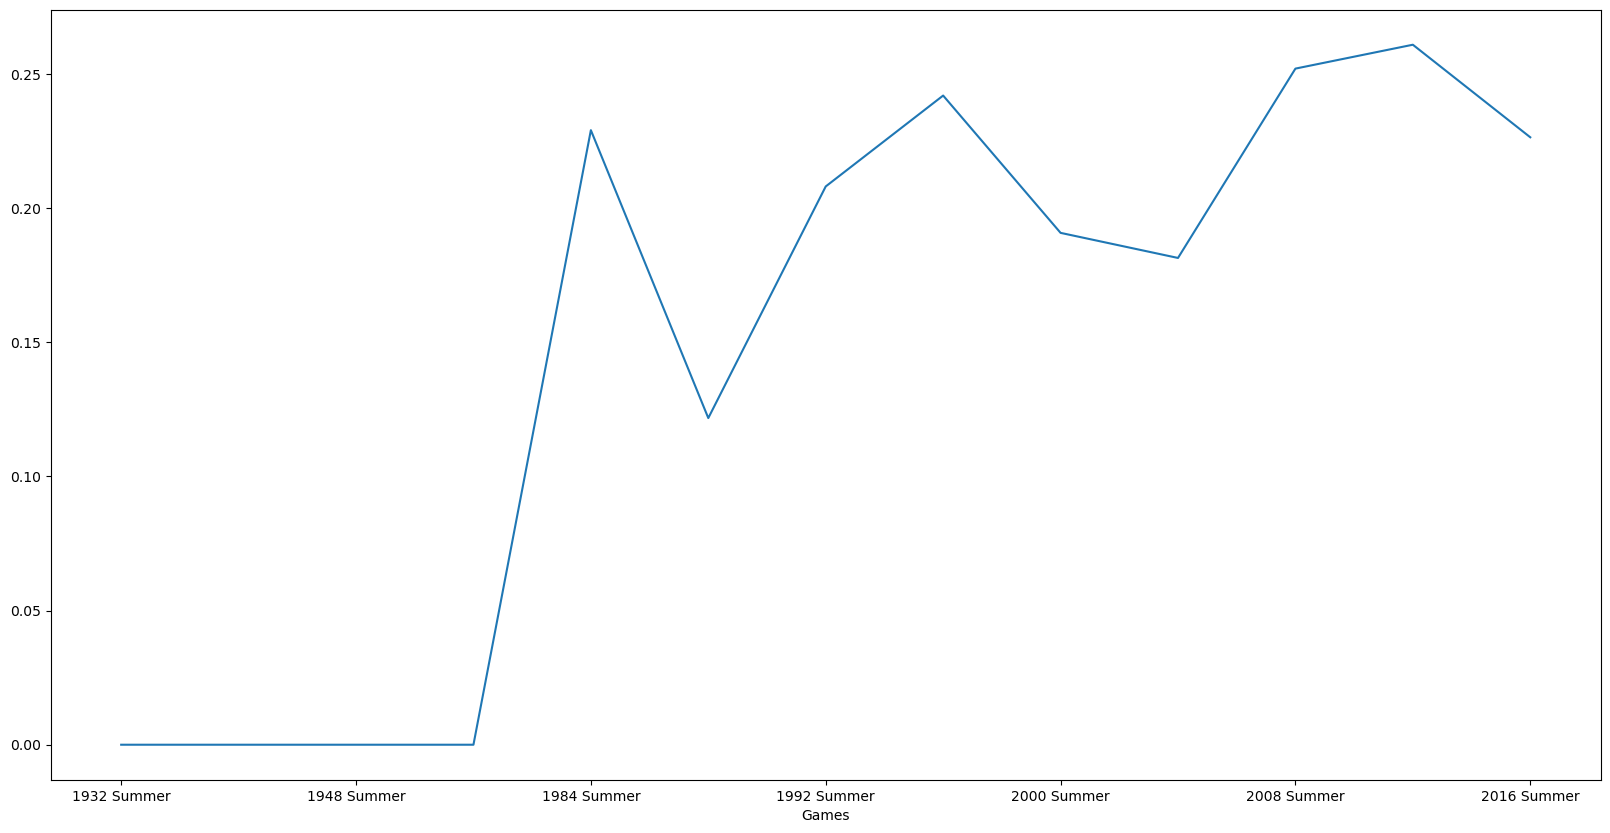

In [37]:
# Use a line chart to plot the medal_rate for the Chinese team in the Summer Olympics.
games_df_china['medal_rate'].plot(kind='line', figsize=(20, 10))

<Axes: xlabel='Games'>

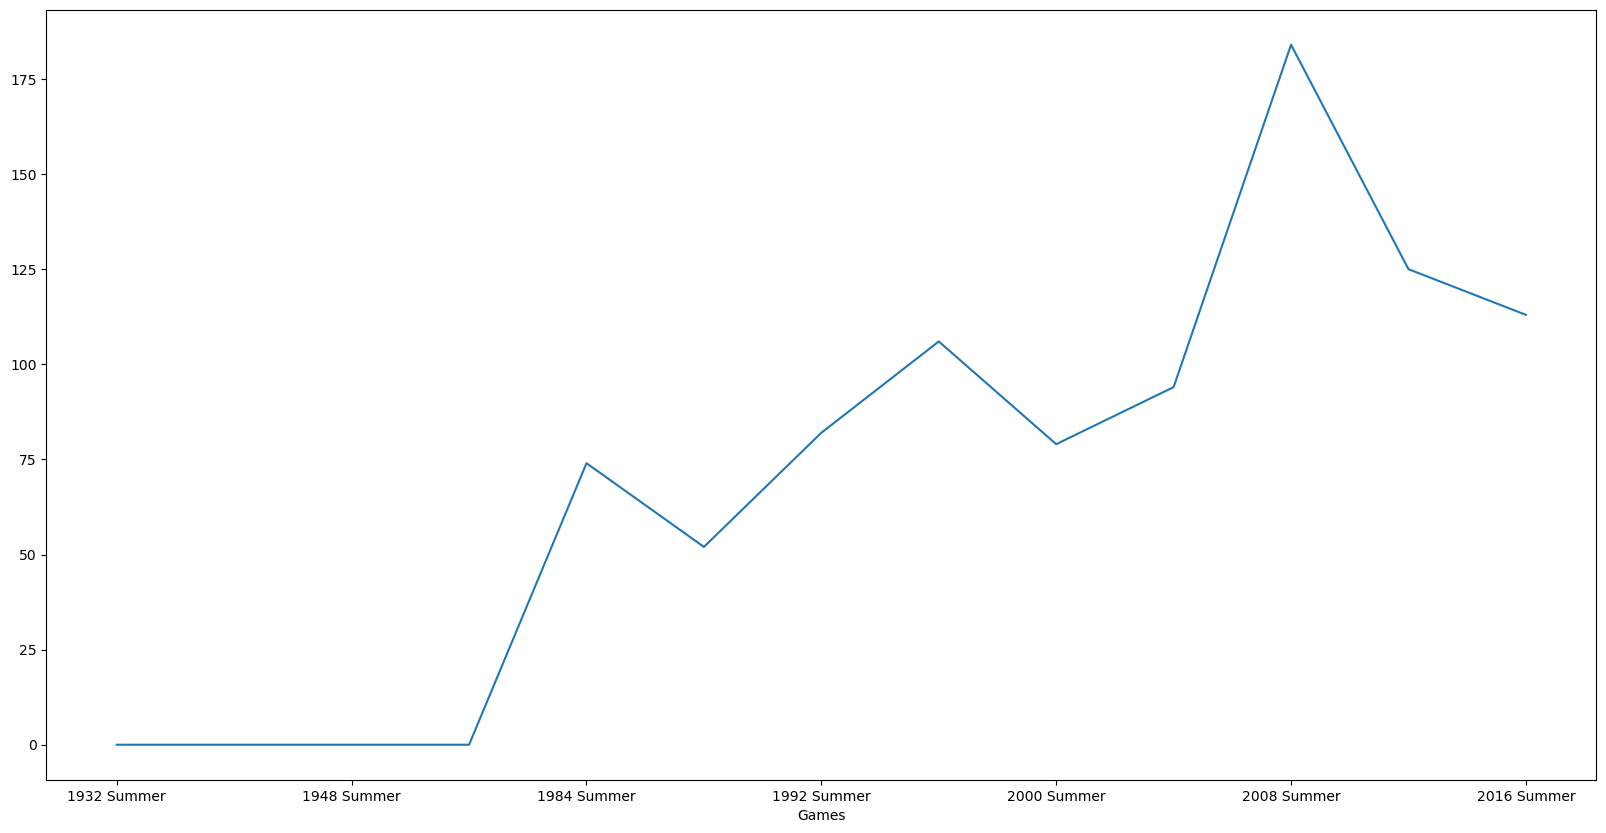

In [38]:
# Use a line chart to plot the medal count for the Chinese team in the Summer Olympics.
games_df_china['total_medals'].plot(kind='line', figsize=(20, 10))



In [39]:
# Calculate the average medal count for the Chinese team for the summer olympics
average_medal_count_china = games_df_china['total_medals'].mean()
print(average_medal_count_china)

# Calculate the average medal count for the Chinese team in the games where they won at least one medal
average_medal_count_china_won = games_df_china[games_df_china['total_medals'] > 0]['total_medals'].mean()
print(average_medal_count_china_won)

69.92307692307692
101.0


In [40]:
# Calculate the standard deviation of the medal count for the Chinese team for the summer olympics
std_dev_medal_count_china = games_df_china['total_medals'].std()
print(std_dev_medal_count_china)

# Calculate the standard deviation of the medal count for the Chinese team in the games where they won at least one medal
std_dev_medal_count_china_won = games_df_china[games_df_china['total_medals'] > 0]['total_medals'].std()
print(std_dev_medal_count_china_won)

57.667815313889975
38.17394399325278


In [41]:
# Show the medal count for the 2008 Summer Games
games_df_china.loc['2008 Summer'] 

Medal                       184.000000
gold_medals                  74.000000
silver_medals                53.000000
bronze_medals                57.000000
non_medal_participations    546.000000
total_participations        730.000000
total_medals                184.000000
medal_rate                    0.252055
gold_percentage               0.402174
silver_percentage             0.288043
bronze_percentage             0.309783
non_medal_percentage          0.747945
Name: 2008 Summer, dtype: float64

In [42]:
from scipy.stats import zscore

# add z_scores column to the games_df_china dataframe
games_df_china['z_scores'] = zscore(games_df_china['total_medals'])
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,non_medal_participations,total_participations,total_medals,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage,z_scores
Games,,,,,,,,,,,,,
1932 Summer,0,0,0,0,2,2,0,0.000000,NaN,NaN,NaN,1.000000,-1.262025
1936 Summer,0,0,0,0,65,65,0,0.000000,NaN,NaN,NaN,1.000000,-1.262025
1948 Summer,0,0,0,0,33,33,0,0.000000,NaN,NaN,NaN,1.000000,-1.262025
1952 Summer,0,0,0,0,1,1,0,0.000000,NaN,NaN,NaN,1.000000,-1.262025
1984 Summer,74,24,13,37,249,323,74,0.229102,0.324324,0.175676,0.500000,0.770898,0.073583
1988 Summer,52,6,16,30,375,427,52,0.121780,0.115385,0.307692,0.576923,0.878220,-0.323489
1992 Summer,82,18,45,19,312,394,82,0.208122,0.219512,0.548780,0.231707,0.791878,0.217974
1996 Summer,106,19,70,17,332,438,106,0.242009,0.179245,0.660377,0.160377,0.757991,0.651144
2000 Summer,79,39,23,17,335,414,79,0.190821,0.493671,0.291139,0.215190,0.809179,0.163827


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_medals', ylabel='Count'>

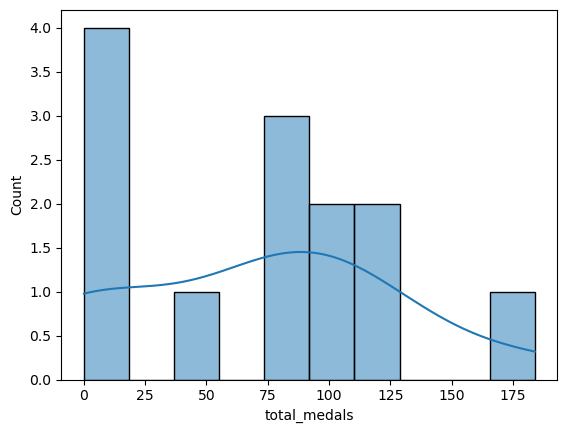

In [43]:
import seaborn as sns

# Plot the distribution of the medal count for the Chinese team in the Summer Olympics
sns.histplot(games_df_china['total_medals'], bins=10, kde=True)